In [1]:
# The ultimate target feature: time from one stop to another

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from statsmodels.formula.api import ols

# Read csv file into a dataframe.
df = pd.read_csv('csv_data/route4.csv')

/Users/user/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1.0 Data Cleaning 

## 1.1 Rename column names

In [2]:
df = df.rename(columns={'Timeframe': 'Start_date'})

## 1.2 Dropping duplicates

In [3]:
df=df.drop_duplicates(keep='first')

## 1.3 Dropping constant columns or columns with missing data

In [4]:
df = df.drop('Direction', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Congestion', axis=1)
df[df.Journey_Pattern_ID == 'null']
df = df[df['Journey_Pattern_ID'] != '00040002']
df = df[df['Journey_Pattern_ID'] != '00041002']

## 1.4 Remove rows where bus is not at stop

In [5]:
df = df.loc[(df != 0).all(axis=1), :]

## 1.5 Group to normalise time & remove rows where bus idle at stop

In [6]:
# Create empty column which will hold normalised time
df['normal_time'] = 0

In [7]:
# Create empty column which will hold the stop order
df['stop_order'] = 0

In [8]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [9]:
def normalize_time(df):
    """Normalise the time for each journey"""
    for i in range(df['Timestamp'].size):
        df['normal_time'].values[i] = (df['Timestamp'].values[i] - df['Timestamp'].values[0]) / 1000000
        
    return df

In [10]:
norm_gb = grouped_df.apply(normalize_time)

In [11]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [12]:
def remove_idle_at_stop(df):
    df = df.drop_duplicates(subset='Stop_ID', keep='first')
    
    return df

In [13]:
norm_gb = grouped_df.apply(remove_idle_at_stop)

In [14]:
grouped_df = norm_gb.groupby(['Vehicle_Journey_ID', 'Start_date'])

/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Vehicle_Journey_ID' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':
/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Start_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [15]:
def route_order(df):
    for i in range(df['Timestamp'].size):
        df['stop_order'].values[i] = i+1
    
    return df

In [16]:
df = grouped_df.apply(route_order)

In [17]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Vehicle_Journey_ID' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':
/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Start_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [18]:
#removed crystallising end stop as take that out later on - for flexibility to run checks beforehand
#have to add stops near the beginning as just the first stop is not capturing all journies, drivers must not be setting the 
#vehicle journey ID before starting off
def stop_start_only(df):
    if ( (df['Stop_ID'][0] == '7330') | (df['Stop_ID'][0] == '7113') | (df['Stop_ID'][0] == '324') | (df['Stop_ID'][0] == '327') | (df['Stop_ID'][0] == '2051')| (df['Stop_ID'][0] == '6086')):
                                                                        
        df['full_trip'] = 1
    return df

In [19]:
df = grouped_df.apply(stop_start_only)

In [20]:
df = df.loc[df['full_trip'] == 1]

## 1.6 Add new features

In [21]:
df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

In [22]:
df['IsWeekend'] = np.where((df['Time'].dt.dayofweek > 5), 1, 0)

In [23]:
df['HourOfDay'] = df['Time'].dt.hour

In [24]:
df['MinsOfHour'] = df['Time'].dt.minute

In [25]:
df['DayOfWeek'] = df['Time'].dt.dayofweek

In [26]:
df['IsEveningTime'] = np.where((df['Time'].dt.hour > 17), 1, 0)

In [27]:
df['Direction_north'] = np.where((df['Journey_Pattern_ID'] == '00041001'), 1,0)

In [28]:
df['IsPeakTime'] = np.where(((df['HourOfDay'] >= 7) & (df['HourOfDay'] <= 10)) | ((df['HourOfDay'] >= 16) & (df['HourOfDay'] <= 19)), 1, 0)

In [29]:
df['RDS_Event'] = np.where((df['Time'].dt.date == datetime(2013, 1, 27).date()), 1, 0)

In [30]:
df['BankHoliday'] = np.where((df['Time'].dt.date == datetime(2013, 1, 1).date()), 1, 0)

In [31]:
df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2012, 11, 1).date()) | (

df['Time'].dt.date == datetime(2012, 11, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

# 2.0 Merge Datasets

## 2.1 Merge bus stop info

In [32]:
df_bus_stop = pd.read_csv('csv_data/busstopinfo.csv', encoding='latin-1')

In [33]:
df_bus_stop = df_bus_stop.rename(columns={'stopid': 'Stop_ID'})
df_bus_stop = df_bus_stop.rename(columns={'fullname': 'Stop_name'})

In [34]:
df_bus_stop = df_bus_stop[['Stop_ID', 'Stop_name']]

In [35]:
df = pd.merge(df, df_bus_stop, on=['Stop_ID'])

In [36]:
grouped_df = df.groupby(['Vehicle_Journey_ID', 'Start_date'])

In [37]:
grouped_df.get_group((4558, '2013-01-03'))

,At_Stop,Block_ID,Delay,Journey_Pattern_ID,Lat,LineID,Lon,Operator,Start_date,Stop_ID,...,HourOfDay,MinsOfHour,DayOfWeek,IsEveningTime,Direction_north,IsPeakTime,RDS_Event,BankHoliday,SchoolHoliday,Stop_name
19130,1,4003,42,00040001,53.402534,4.0,-6.264970,HN,2013-01-03,7113,...,8,21,3,0,0,1,0,0,1,Ballymun Road
19680,1,4003,42,00040001,53.399124,4.0,-6.263812,HN,2013-01-03,127,...,8,23,3,0,0,1,0,0,1,Ballymun Road
20140,1,4003,97,00040001,53.396149,4.0,-6.264059,HN,2013-01-03,112,...,8,26,3,0,0,1,0,0,1,Ballymun Road
20982,1,4003,23,00040001,53.385361,4.0,-6.265003,HN,2013-01-03,37,...,8,30,3,0,0,1,0,0,1,Ballymun Road
22072,1,4003,-369,00040001,53.365372,4.0,-6.271678,HN,2013-01-03,186,...,8,36,3,0,0,1,0,0,1,Prospect Road
22499,1,4003,-426,00040001,53.362782,4.0,-6.272560,HN,2013-01-03,187,...,8,37,3,0,0,1,0,0,1,Phibsboro Road
23002,1,4003,-401,00040001,53.360115,4.0,-6.272670,HN,2013-01-03,188,...,8,38,3,0,0,1,0,0,1,Phibsboro Road
23467,1,4003,-527,00040001,53.352112,4.0,-6.261073,HN,2013-01-03,4725,...,8,46,3,0,0,1,0,0,1,O'Connell St
24078,1,4003,-514,00040001,53.347191,4.0,-6.258871,HN,2013-01-03,273,...,8,50,3,0,0,1,0,0,1,O'Connell St
24674,1,4003,-543,00040001,53.342419,4.0,-6.255597,HN,2013-01-03,405,...,8,54,3,0,0,1,0,0,1,Nassau Street


In [38]:
grouped_df.get_group((4542, '2013-01-15'))

,At_Stop,Block_ID,Delay,Journey_Pattern_ID,Lat,LineID,Lon,Operator,Start_date,Stop_ID,...,HourOfDay,MinsOfHour,DayOfWeek,IsEveningTime,Direction_north,IsPeakTime,RDS_Event,BankHoliday,SchoolHoliday,Stop_name
531,1,4001,7,00041001,53.286362,4.0,-6.165994,HN,2013-01-15,6086,...,6,48,1,0,1,0,0,0,0,Link Road
1227,1,4001,7,00041001,53.292568,4.0,-6.166771,HN,2013-01-15,3163,...,6,51,1,0,1,0,0,0,0,Stradbrook Rd
1571,1,4001,-159,00041001,53.301456,4.0,-6.181077,HN,2013-01-15,3084,...,6,55,1,0,1,0,0,0,0,Frascati Road
2261,1,4001,-174,00041001,53.307972,4.0,-6.194847,HN,2013-01-15,472,...,6,59,1,0,1,0,0,0,0,Rock Road
2673,1,4001,-217,00041001,53.310928,4.0,-6.199994,HN,2013-01-15,4705,...,7,0,1,0,1,1,0,0,0,Rock Road
2883,1,4001,-199,00041001,53.312775,4.0,-6.201784,HN,2013-01-15,475,...,7,1,1,0,1,1,0,0,0,Rock Road
3343,1,4001,-187,00041001,53.318165,4.0,-6.211247,HN,2013-01-15,478,...,7,4,1,0,1,1,0,0,0,Merrion Road
4316,1,4001,-166,00041001,53.328331,4.0,-6.228619,HN,2013-01-15,485,...,7,10,1,0,1,1,0,0,0,Ballsbridge
4949,1,4001,-161,00041001,53.330879,4.0,-6.233802,HN,2013-01-15,487,...,7,12,1,0,1,1,0,0,0,Pembroke Road
5825,1,4001,-209,00041001,53.337879,4.0,-6.241288,HN,2013-01-15,491,...,7,15,1,0,1,1,0,0,0,Mount St


In [39]:
df.shape

(36429, 28)

## 2.2 Merge weather data

In [40]:
df_weather = pd.read_csv('csv_data/weather_data.csv', encoding='latin-1')

In [41]:
df_weather = df_weather.rename(columns={'Rainfall (Yes or No)': 'Rain'})
df_weather = df_weather.rename(columns={'Temperature C': 'Temperature'})
df_weather = df_weather.rename(columns={'Relative Humidity (%)': 'Humidity'})
df_weather = df_weather.rename(columns={'Over 1mm Rain?': 'Heavy_rain'})
df_weather = df_weather.rename(columns={'Precipitation (mm)': 'Precipitation'})
df_weather = df_weather.rename(columns={'Date': 'Time'})
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['HourOfDay'] = df_weather['Time'].dt.hour

In [42]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')

In [43]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['At_Stop', 'Block_ID', 'Delay', 'Journey_Pattern_ID', 'Lat', 'LineID',
       'Lon', 'Operator', 'Start_date', 'Stop_ID', 'Timestamp', 'Vehicle_ID',
       'Vehicle_Journey_ID', 'full_trip', 'normal_time', 'stop_order', 'Time',
       'IsWeekend', 'HourOfDay_x', 'MinsOfHour', 'DayOfWeek', 'IsEveningTime',
       'Direction_north', 'IsPeakTime', 'RDS_Event', 'BankHoliday',
       'SchoolHoliday', 'Stop_name', 'Precipitation', 'Temperature',
       'Vapour Pressure (hPa)                ', 'Humidity',
       'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain'],
      dtype='object')

In [44]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)

In [45]:
df['Proper_rain'] = np.where(((df['Precipitation'] < 2.3) & (df['Precipitation'] > 1.7) & (df['IsPeakTime']==1)), 1, 0)

# 3.0 Remove and categories columns

## 3.1 Drop missing values

In [46]:
df = df[df['Journey_Pattern_ID'] != 'null']

## 3.2 Categorise to continuous and categorical

In [47]:
df['IsWeekend'] = df['IsWeekend'].astype('category')
df['HourOfDay'] = df['HourOfDay'].astype('category')
df['IsEveningTime'] = df['IsEveningTime'].astype('category')
df['SchoolHoliday'] = df['SchoolHoliday'].astype('category')
df['IsPeakTime'] = df['IsPeakTime'].astype('category')
df['Operator'] = df['Operator'].astype('category')
df['At_Stop'] = df['At_Stop'].astype('category')
categorical_columns = df.select_dtypes(['category']).columns

In [48]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns

## 3.3 Drop columns no longer needed

In [49]:
df = df.drop('Lat', axis=1)
df = df.drop('Lon', axis=1)
df = df.drop('Block_ID', axis=1)
df = df.drop('Operator', axis=1)

## 3.4 Create time to destination feature

In [50]:
df['end_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(max)

In [51]:
df['start_time'] = df.groupby(['Vehicle_Journey_ID', 'Start_date'])['Timestamp'].transform(min)

In [52]:
df['time_diff_to_destination'] = df['end_time'] - df['Timestamp']
df.shape

(36370, 35)

In [53]:
df_count = df.loc[(df.DayOfWeek == 0)]
df_count.shape

(6071, 35)

In [54]:
df['late'] = ((df['end_time'] - df['start_time']) )
df['time_travelling'] = ((df['Timestamp'] - df['start_time']) )
df['journey_time'] = pd.to_timedelta(df['late']*1000, unit="ns").astype('timedelta64[m]')
df['mins_late'] = ((df['journey_time'].astype(int) - 60))
df['late'] = np.where((df['mins_late'] > 1), 1, 0)
df = df.loc[ (df.Stop_ID == '7226') | (df.Stop_ID == '322') | (df.Stop_ID == '332') | (df.Stop_ID == '6085')| (df.Stop_ID == '2026')]
df['speed']= ((df['time_travelling'].astype('float64') / df['stop_order'].astype('float64')) )

In [55]:
df_count = df.loc[(df.DayOfWeek == 0)]
df_count.shape

(284, 40)

In [56]:
#df = df.loc[(df.Stop_ID == '7113') | (df.Stop_ID == '7330') | (df.Stop_ID == '7226') | (df.Stop_ID == '322')]

In [57]:
df.columns

Index(['At_Stop', 'Delay', 'Journey_Pattern_ID', 'LineID', 'Start_date',
       'Stop_ID', 'Timestamp', 'Vehicle_ID', 'Vehicle_Journey_ID', 'full_trip',
       'normal_time', 'stop_order', 'Time', 'IsWeekend', 'HourOfDay',
       'MinsOfHour', 'DayOfWeek', 'IsEveningTime', 'Direction_north',
       'IsPeakTime', 'RDS_Event', 'BankHoliday', 'SchoolHoliday', 'Stop_name',
       'Precipitation', 'Temperature', 'Vapour Pressure (hPa)                ',
       'Humidity', 'Mean Sea Level Pressure (hPa)', 'Rain', 'Heavy_rain',
       'Proper_rain', 'end_time', 'start_time', 'time_diff_to_destination',
       'late', 'time_travelling', 'journey_time', 'mins_late', 'speed'],
      dtype='object')

In [58]:
#grouped_df.get_group((4601, '2013-01-29'))

In [59]:
df['Vehicle_Journey_ID'] = pd.to_numeric(df['Vehicle_Journey_ID'], errors='coerce')

#    # Extra plots

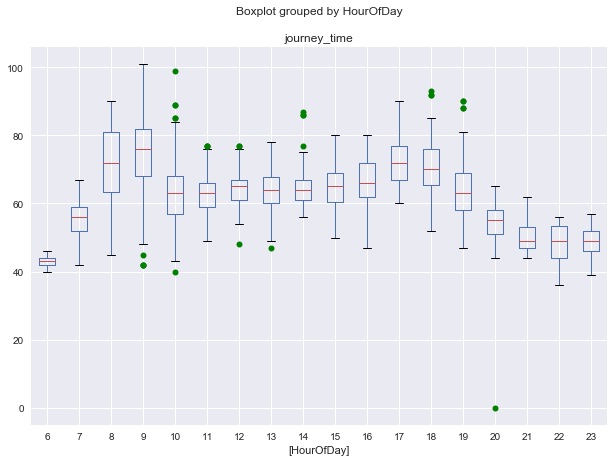

In [60]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['HourOfDay'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Temp_to_late.pdf')

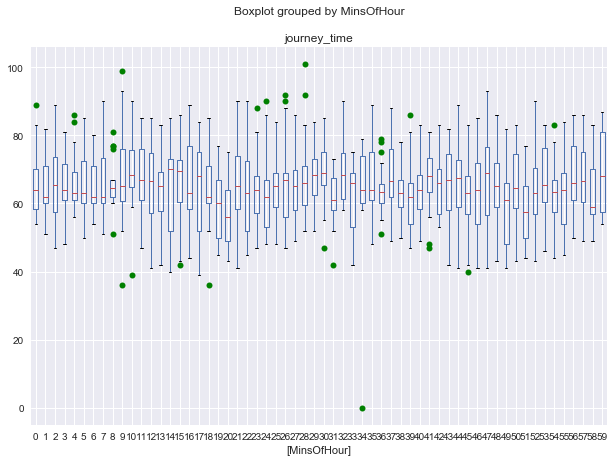

In [61]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['MinsOfHour'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Mins_to_journey_time.pdf')

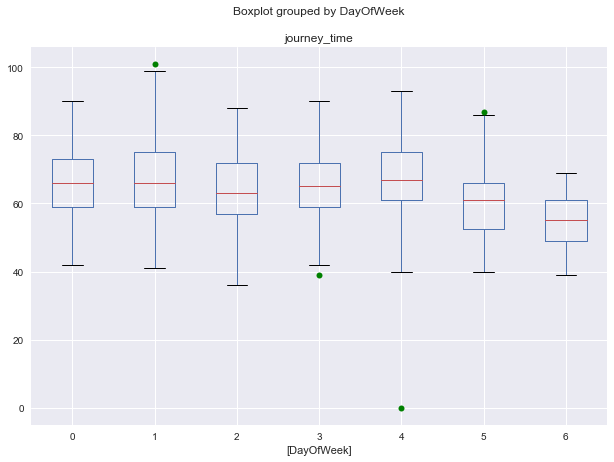

In [62]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['DayOfWeek'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_DayOfWeek_chart.pdf')

What is this telling us that there are absolutely no outliers here?

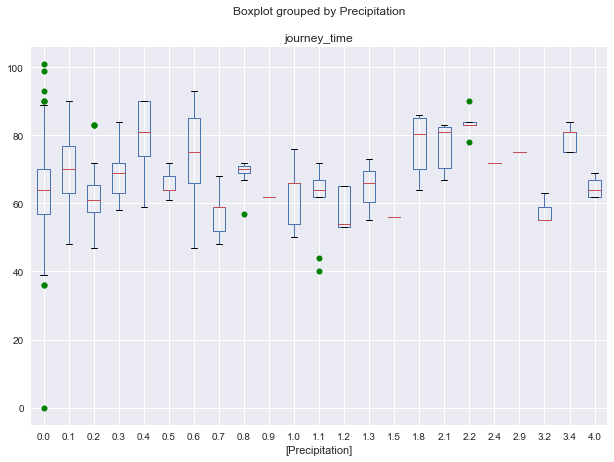

In [63]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Precipitation'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_late.pdf')

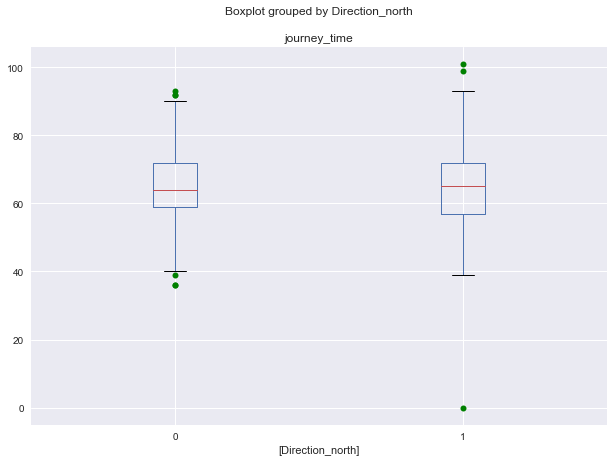

In [64]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['journey_time'], by=['Direction_north'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Journey_Pattern_ID_to_late.pdf')

Represents direction

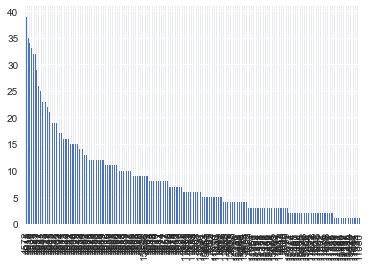

In [65]:
df.Vehicle_Journey_ID.value_counts().plot(kind='bar')

More buses running certain vehicle journey IDs

In [66]:
df.Vehicle_Journey_ID.unique()

array([15475, 15488, 15493, 15483,  4894,  4905,  4542,  4951,  4572,
        4585,  4936,  4915,  4906,  4952,  4543,  4558,  4575,  4925,
        4573,  4601,  4586,  4916,  4559,  4587,  4917,  4545,  4954,
        4918,  4898,  4561,  4579,  4590,  4929,  4957,  4591,  4549,
        4592,  4913,  4902,  4582,  4959,  4933,  4593,  4903,  4934,
        4945,  4904,  4568,  4949,  4555,  4895,  4896,  4937,  4544,
        4926,  4938,  4897,  4577,  4560,  4588,  4919,  4940,  4547,
        4562,  4920,  4563,  4942,  4564,  4565,  4932,  4944,  4923,
        4924,  4935,  4597,  4557,  4907,  4576,  4908,  4927,  4955,
        4910,  4911,  4580,  4958,  4550,  4594,  4595,  4947,  4946,
       11064, 11346, 11078, 11066, 11347, 11079, 11067, 11080, 11353,
       11068, 11349, 11092, 11093, 11339, 11351, 11083, 11096, 11097,
       11088, 15486, 15487, 15478, 15664, 15489, 15479, 15666, 15481,
       15482, 15670, 15495, 15485,  4556,  4953,  4928,  4900,  4921,
        4943,  4914,

In [67]:
import statsmodels.formula.api as sm

# Train all continuous features.
check1 = sm.ols(formula="journey_time ~ Proper_rain", data=df).fit()
# Print the weights learned for each feature.
print(check1.summary())

                            OLS Regression Results                            
Dep. Variable:           journey_time   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     45.12
Date:                Fri, 30 Jun 2017   Prob (F-statistic):           2.58e-11
Time:                        13:15:48   Log-Likelihood:                -5894.0
No. Observations:                1561   AIC:                         1.179e+04
Df Residuals:                    1559   BIC:                         1.180e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      64.6304      0.270    239.609      

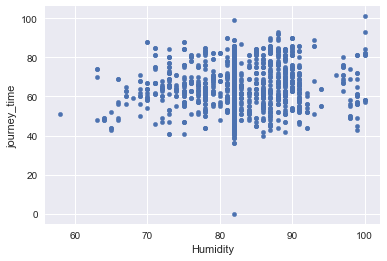

In [68]:
df.plot(kind = 'scatter', y='journey_time', x='Humidity')

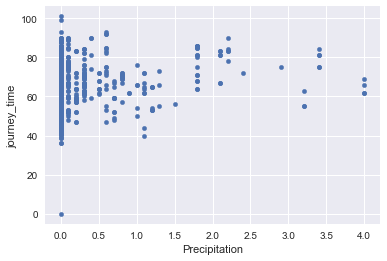

In [69]:
df.plot(kind = 'scatter', y='journey_time', x='Precipitation')

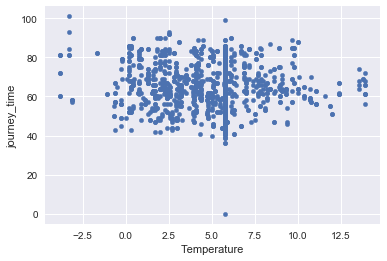

In [70]:
df.plot(kind = 'scatter', y='journey_time', x='Temperature')

In [71]:
df_check_journey_ID = df.loc[df['mins_late'] > 1]
df_check_journey_ID = df_check_journey_ID[['late','Vehicle_Journey_ID']]
df_check_journey_ID.Vehicle_Journey_ID.unique()

array([ 4585,  4906,  4543,  4575,  4925,  4601,  4586,  4917,  4545,
        4954,  4918,  4898,  4561,  4579,  4929,  4591,  4549,  4592,
        4913,  4902,  4959,  4933,  4593,  4903,  4936,  4895,  4952,
        4558,  4916,  4937,  4544,  4587,  4938,  4577,  4560,  4588,
        4919,  4940,  4547,  4562,  4920,  4563,  4564,  4565,  4932,
        4944,  4915,  4907,  4576,  4908,  4927,  4955,  4911,  4580,
        4958,  4550,  4594,  4923, 11080, 11349, 11093, 11339, 11083,
       15664, 15489,  4951,  4897,  4928,  4590,  4900,  4943,  4582,
        4573,  4953,  4546,  4912,  4926,  4910,  4942,  4931,  4572,
        4559,  4578,  4589,  4921,  4914,  4896,  4909,  4941,  4957,
        4930,  4901,  4922,  4934, 11353, 11091, 11338, 11350, 11070,
       11351, 11071, 11357, 11095, 11085, 15663, 15488,  4956,  4905,
        4542,  4899,  4548,  4551, 11336, 11348, 11337, 11094,  4574,
        4960,  4945,  4566,  4584, 11335, 11347, 11090, 11354, 11092,
       15665, 15481]

If Vehicle Journey ID starts with 9 it is never late

In [72]:
df_check_2 = df.loc[(df.Vehicle_Journey_ID == 4585) & (df.Stop_ID == '7226')]
df_check_2.Time

297     2013-01-02 08:22:59
1574    2013-01-03 08:21:18
3136    2013-01-04 08:29:35
5791    2013-01-07 08:41:04
10580   2013-01-10 08:30:42
12208   2013-01-11 08:41:11
15216   2013-01-14 08:41:52
16599   2013-01-15 08:39:06
21640   2013-01-18 08:35:24
24043   2013-01-21 08:41:30
25498   2013-01-22 08:32:19
27029   2013-01-23 08:42:54
32345   2013-01-28 08:38:46
33687   2013-01-29 08:43:20
Name: Time, dtype: datetime64[ns]

(0, 100)

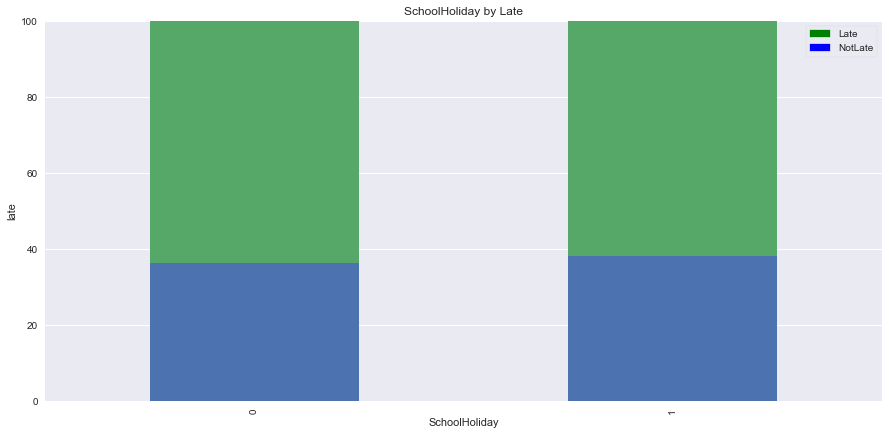

In [73]:
SchoolHoliday = pd.unique(df.SchoolHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.SchoolHoliday == p].count()['late']
    index_list = df[df['SchoolHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','SchoolHoliday','late']].groupby(['SchoolHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="SchoolHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("SchoolHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

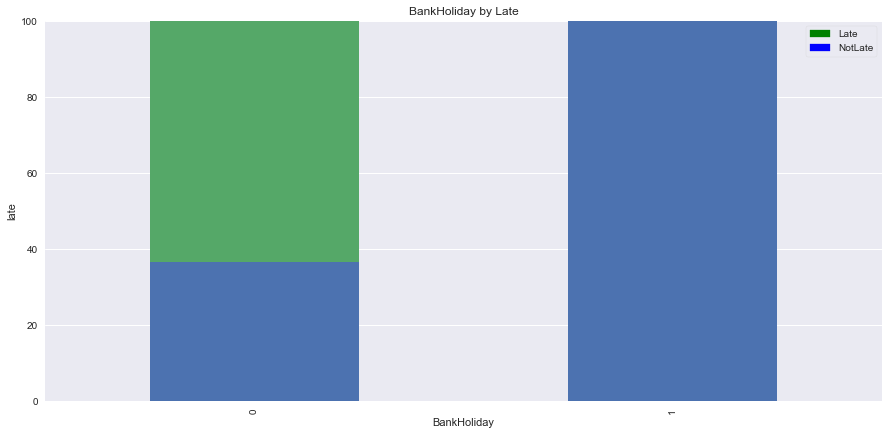

In [74]:
BankHoliday = pd.unique(df.BankHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in BankHoliday:
    count = 1 / df[df.BankHoliday == p].count()['late']
    index_list = df[df['BankHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','BankHoliday','late']].groupby(['BankHoliday','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="BankHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("BankHoliday")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

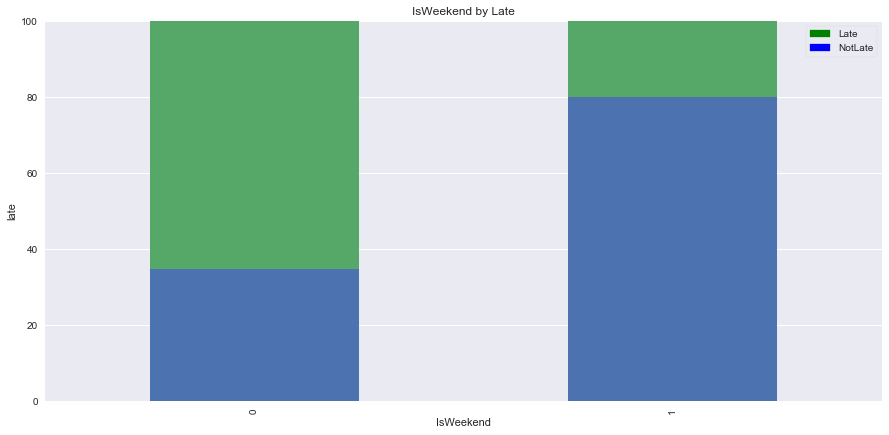

In [75]:
IsWeekend = pd.unique(df.IsWeekend.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.IsWeekend == p].count()['late']
    index_list = df[df['IsWeekend'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','IsWeekend','late']].groupby(['IsWeekend','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="IsWeekend by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("IsWeekend")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

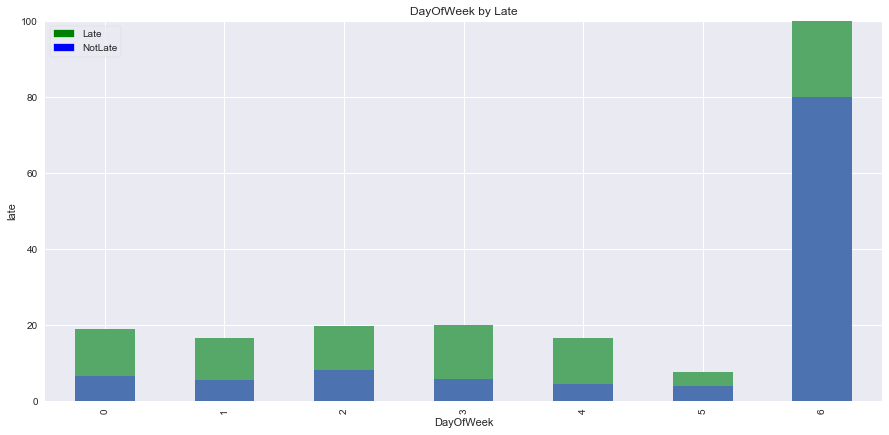

In [76]:
# Group dataframe  and sum percent
group = df[['percent','DayOfWeek','late']].groupby(['DayOfWeek','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="DayOfWeek by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("DayOfWeek")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

(0, 100)

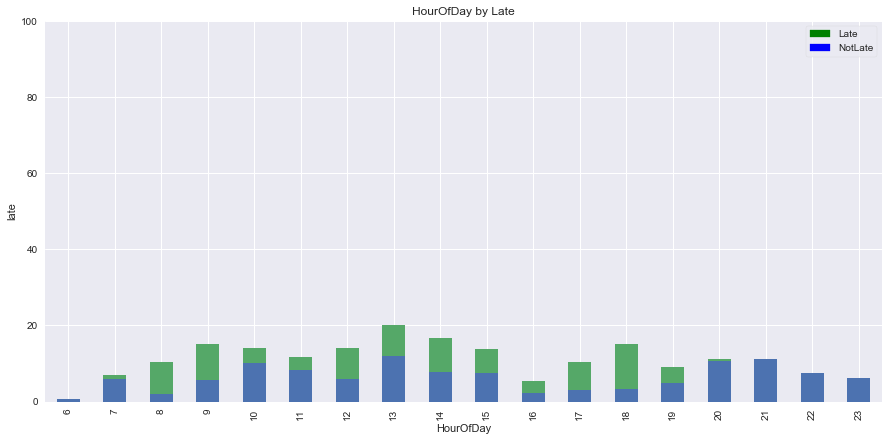

In [77]:
# Group dataframe and sum percent
group = df[['percent','HourOfDay','late']].groupby(['HourOfDay','late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="HourOfDay by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("HourOfDay")
my_plot.set_ylabel("late")
my_plot.set_ylim([0,100])

In [78]:
bins=[10,20,30,40,50,60,70,80,90,100,110]

In [79]:
df['time_bins'] = np.digitize(df.journey_time.values, bins=bins)
df.time_bins.unique()

array([ 4,  5,  6,  7,  3,  8,  9,  0, 10])

In [80]:
df.shape

(1561, 42)

In [81]:
df_check_journey_time = df.loc[df['journey_time'] < 20]
df_check_journey_time = df_check_journey_time[['journey_time','Vehicle_Journey_ID', 'Time', 'stop_order', 'Stop_ID', 'end_time']]
df_check_journey_time.sort_values(['journey_time'], ascending=[True])

,journey_time,Vehicle_Journey_ID,Time,stop_order,Stop_ID,end_time
13660,0.0,4904,2013-01-11 20:34:46,2,332,1357936486000000


# 4.0 Save DF to be used in Model Analysis

In [82]:
# Save cleaned dataframe to new CSV file
df.to_csv('csv_data/bus_route4_clean.csv', index=False)

---

In [83]:
df_train = df[:130000]

In [84]:
df_test = df[130000:]

df_group = df.groupby(['Vehicle_Journey_ID', 'Start_date'])